In [1]:
%pylab inline
from simqso.sqgrids import *
from simqso import sqbase
from astropy.cosmology import WMAP9

Populating the interactive namespace from numpy and matplotlib


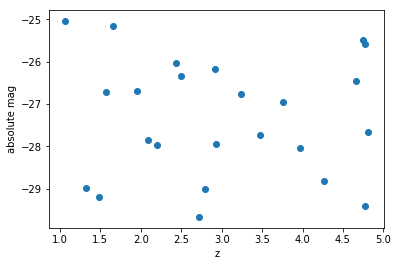

In [2]:
# set up a luminosity-redshift grid
M = AbsMagVar(GridSampler(-30,-25,nbins=4),restWave=1450)
z = RedshiftVar(GridSampler(1,5,nbins=3))
MzGrid = QsoSimGrid([M,z],2)
scatter(MzGrid.z,MzGrid.absMag)
xlabel('z')
ylabel('absolute mag')

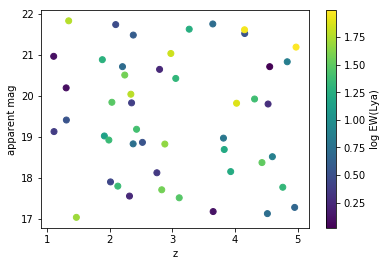

In [3]:
# set up a flux-redshift grid with Lya EW as a third dimension
m = AppMagVar(GridSampler(17,22,nbins=4),band='i')
lya = GaussianLineEqWidthVar(GridSampler(0,2,nbins=2),'LyaEW',1215.67,10.)
mzlyaGrid = QsoSimGrid([m,z,lya],2)
scatter(mzlyaGrid.z,mzlyaGrid.appMag,c=mzlyaGrid.LyaEW)
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('log EW(Lya)')

In [4]:
# Generate m,z points by sampling from a model QLF
from simqso.lumfun import QLF_McGreer_2013
cosmo=WMAP9
m2M = lambda z: sqbase.mag2lum('SDSS-i',1450,z,cosmo)
qlfGrid = generateQlfPoints(QLF_McGreer_2013,(17,22),(4.5,5.3),m2M,cosmo,'SDSS-i',skyArea=100)
qlfGrid.addVar(AbsMagVar(FixedSampler(qlfGrid.appMag-m2M(qlfGrid.z))))

integration returned  43  objects


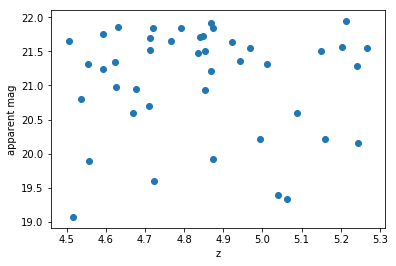

In [5]:
scatter(qlfGrid.z,qlfGrid.appMag)
xlabel('z')
ylabel('apparent mag')

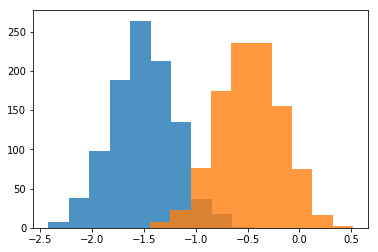

In [6]:
# test the canonical values for power law continuum slopes in FUV/NUV
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),GaussianSampler(-0.5,0.3)],[1215.])
contVals = contVar(1000)
_ = hist(contVals[:,0],alpha=0.8)
_ = hist(contVals[:,1],alpha=0.8)

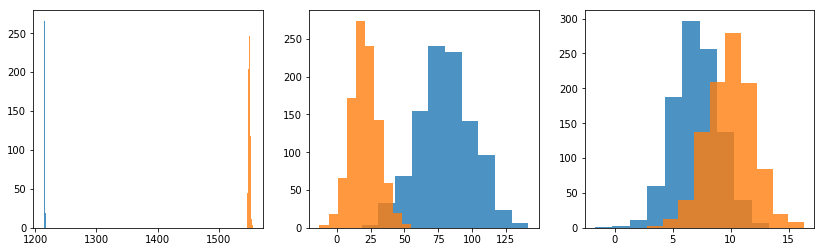

In [7]:
# Add gaussian emission lines
g = GaussianSampler
lya = [g(1215.7,0.5),g(80,20),g(7,2)]
civ = [g(1550.0,1.5),g(20,10),g(10,2)]
emLinesVar = GaussianEmissionLinesTemplateVar([lya,civ])
emLinesVals = emLinesVar(1000)
figure(figsize=(14,4))
for k in range(3):
    subplot(1,3,k+1)
    for j in range(2):
        hist(emLinesVals[:,j,k],alpha=0.8)

In [8]:
# add gaussian lines to the qlf grid
qlfGrid.addVar(emLinesVar)
print qlfGrid

    appMag          z           absMag             emLines [2,3]         
------------- ------------- -------------- ------------------------------
21.7239792916 4.84778465735 -24.7459789211 1215.45630504 .. 12.0418474783
19.9239666321 4.87422719732 -26.5574534344 1215.58362951 .. 9.85701505073
19.3926775544  5.0390403277  -27.158678407 1216.03829685 .. 6.98605857173
21.3096808788 5.01291256905 -25.2307570784  1215.23328081 .. 13.747999055
21.9113600762 4.86932583617 -24.5679405961  1215.29320413 .. 12.604895109
21.5554922311  4.9676827451  -24.965897097 1215.59098045 .. 10.9160986959
20.9411022448 4.67650264744 -25.4529077771 1215.87046995 .. 11.1691002647
21.8445150976 4.72068050158  -24.569372799 1216.12269429 .. 11.9407637392
 21.650453355 4.50714054258  -24.665392736 1215.85383706 .. 7.23130934236
20.9286207974 4.85347964525  -25.543811771 1214.65405367 .. 10.0257273914
          ...           ...            ...                            ...
21.7505694896 4.59326896654 -24.605422

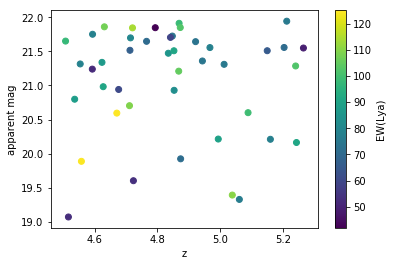

In [9]:
scatter(qlfGrid.z,qlfGrid.appMag,c=qlfGrid.emLines[:,0,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(Lya)')

In [10]:
# Now use the BOSS DR9 emission line template, including the Baldwin Effect
lineTemplate = generateBEffEmissionLines(qlfGrid.absMag)
lines = lineTemplate()
lines.shape

(43, 62, 3)

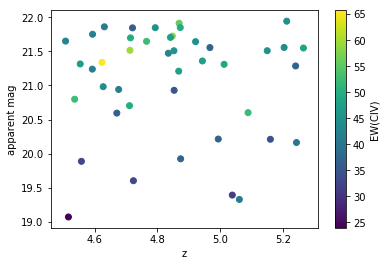

In [11]:
scatter(qlfGrid.z,qlfGrid.appMag,c=lines[:,13,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(CIV)')

In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(qlfGrid.nObj)

using the following lines from VdB template:  Ly{epsilon},CIII,Ly{beta},ArI,FeIII,CIII*,Ly{alpha},NV,SiII,OI,CII,SiIV,CIV,HeII,OIII],NIV,NIII],FeII,SiII,AlIII,SiIII],CIII],FeIII,FeIII,FeII,FeII,FeII,CII],[NeIV],[OII],FeII,AlII],MgII,FeII,OIII,HeI,FeI,FeII,[NeV],[NeV],FeII,[FeVII],[OII],[FeVII],FeII,FeII,[NeIII],HeI,[NeIII],[FeV],H{delta},FeII,FeII,[FeII],[FeII],H{gamma},[OIII],FeII,FeII,HeII,H{beta},FeII,[OIII],[OIII],[FeVII],[FeVI],[NI],[FeVII],FeII,[FeXIV],[ClIII],[FeVII],HeI,[FeVII],[OI],[OI],[NII],H{alpha},[NII],[SII],[SII],HeI,[ArIII],[OII],[NiIII]


In [13]:
wave = arange(3000,1e4,0.5)
z = 2.0
def quick_spec(emlines):
    lineWave,eqWidth,sigma = emlines.T * (1+z)
    spec = np.zeros_like(wave)
    A = eqWidth/(np.sqrt(2*np.pi)*sigma)
    twosig2 = 2*sigma**2
    nsig = np.sqrt(-2*np.log(1e-3/A))
    nsig = (nsig*np.array([[-1.],[1]])).T
    for i in xrange(lineWave.shape[0]):
        i1,i2 = np.searchsorted(wave,lineWave[i]+nsig[i]*sigma[i])
        if i2 != i1:
            lineprofile = A[i]*np.exp(-(wave[i1:i2]-lineWave[i])**2
                                       / twosig2[i])
            spec[i1:i2] += lineprofile
    return spec

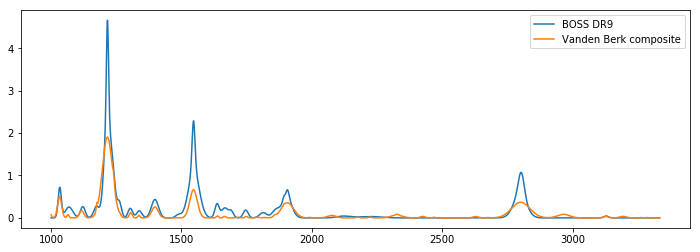

In [14]:
figure(figsize=(12,4))
plot(wave/(1+z),quick_spec(lines[0]),label='BOSS DR9')
plot(wave/(1+z),quick_spec(vdblines[0]),label='Vanden Berk composite')
legend()